Investigating the architectural constraints that limit arithmetic performance in transformer models. Using GPT-2 as a representative case study due to open weights and inspectability.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel


In [2]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained(
    "gpt2",
    output_attentions=True,
    output_hidden_states=True
)
model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [3]:
numbers = ["7", "42", "105", "1000", "10000", "2.5", "1/3", "1000000"]

In [4]:
for n in numbers:
    tokens = tokenizer.tokenize(n)
    print(f"{n:>8} → {tokens}")


       7 → ['7']
      42 → ['42']
     105 → ['105']
    1000 → ['1000']
   10000 → ['10000']
     2.5 → ['2', '.', '5']
     1/3 → ['1', '/', '3']
 1000000 → ['1', '000000']


In [5]:
nums = ["1", "2", "10", "11", "20", "100"]


Single-token integers maintain atomic representation, but decimals and large numbers fragment. This creates immediate issues - the model can't perform digit-level operations when digits aren't consistently grouped.


In [6]:
embeddings = []

for n in nums:
    ids = tokenizer.encode(n, return_tensors="pt")
    with torch.no_grad():
        emb = model.transformer.wte(ids).mean(dim=1)
    embeddings.append(emb.squeeze().numpy())


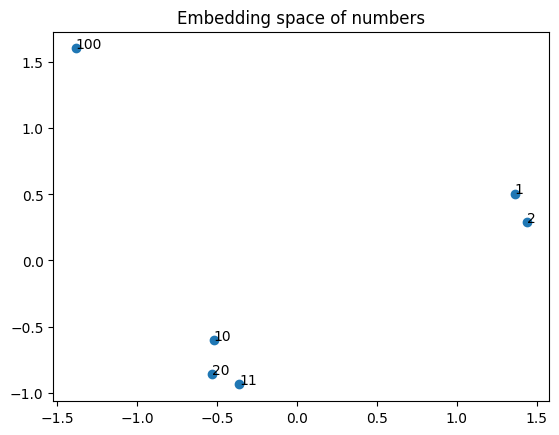

In [7]:
from sklearn.decomposition import PCA

X = np.stack(embeddings)
X2 = PCA(n_components=2).fit_transform(X)

plt.scatter(X2[:,0], X2[:,1])
for i, n in enumerate(nums):
    plt.text(X2[i,0], X2[i,1], n)
plt.title("Embedding space of numbers")
plt.show()


In [8]:
def ask(q):
    ids = tokenizer.encode(q, return_tensors="pt")
    with torch.no_grad():
        out = model.generate(ids, max_new_tokens=10)
    return tokenizer.decode(out[0])


Running simple addition tasks to establish baseline failure rates. Separating no-carry and carry operations to identify if specific algorithmic steps are more problematic.


In [9]:
tests = {
    "no_carry": ["23 + 14 =", "41 + 28 ="],
    "carry": ["27 + 18 =", "58 + 67 ="]
}

for k, qs in tests.items():
    print("\n", k)
    for q in qs:
        print(q, ask(q))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



 no_carry


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


23 + 14 = 23 + 14 = 0.5

The following table shows the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


41 + 28 = 41 + 28 = 0.5

The following table shows the

 carry


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


27 + 18 = 27 + 18 = 0.5

The following table shows the
58 + 67 = 58 + 67 = 0.9

The following table shows the


In [10]:
q = "58 + 67 ="
ids = tokenizer.encode(q, return_tensors="pt")

with torch.no_grad():
    out = model(ids)
    attentions = out.attentions


Examining attention weights during arithmetic processing. For genuine computation, would expect concentrated attention on operands and structured information flow.


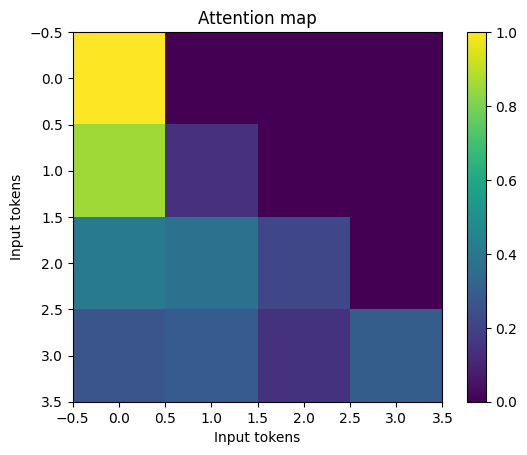

In [11]:
attn = attentions[-1][0,0].cpu().numpy()

plt.imshow(attn, cmap="viridis")
plt.colorbar()
plt.title("Attention map")
plt.xlabel("Input tokens")
plt.ylabel("Input tokens")
plt.show()
